### Neural Network Model

THis notebook will contain the Neural Network taht will do the text generation

I will have a FFNN generate job descriptions, will I do so:

1- First part is the tokenization part take the jb description and have the tokens
2- Create my vocabulary:
        - First I will try with every single toke,
        - SecondI will try with only the top N most frequent token
3- For the token representation I will use a Enbeddings, pre-trained embeddings wit h word2Vec
4- How will I train the FFNN ?
   - I will create Input, Output pairs
        - The Input will be a context window of fixed size N and a Special token <START> and the output is the actual next token
        it will be as followed
        | Input (context window, N=3) | Output (next token) |
        |--------------------------------------|---------------------|
        | ["<START>", "Analyze", "data"]       |     "and"           |
    


Perhaps try dropping job descriptions that are over the thrshold to keep the repartition as gaussean bell (Normal law distribuion)




In [5]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../..')) # Adjust '..' if your notebook is deeper
if project_root not in sys.path:
    sys.path.append(project_root)

In [6]:
import nltk

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("Downloading NLTK 'punkt' tokenizer...")
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("Downloading NLTK 'stopwords'...")
    nltk.download('stopwords')

# Add this check and download for punkt_tab
try:
    # Check for the specific English directory within punkt_tab
    nltk.data.find('tokenizers/punkt_tab/english/') 
except LookupError:
    print("Downloading NLTK 'punkt_tab'...")
    nltk.download('punkt_tab')

print("NLTK resources checked/downloaded.")


NLTK resources checked/downloaded.


In [7]:
import pandas as pd
from models.src.preprocessing.tokenizer import tokenize_data_frame
from data.process_data_modeling import get_processed_data
from sklearn.model_selection import train_test_split
import numpy as np
import logging
import nltk
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange
from collections import Counter
import matplotlib.pyplot as plt
embedding_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
from torch.utils.data import IterableDataset, DataLoader

2025-05-07 08:44:02,790 - INFO - Use pytorch device_name: cuda:0
2025-05-07 08:44:02,791 - INFO - Load pretrained SentenceTransformer: multi-qa-MiniLM-L6-cos-v1


In [8]:


nltk.download('punkt')
nltk.download('stopwords')

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

[nltk_data] Downloading package punkt to /home/cedric/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/cedric/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df = get_processed_data()
df.head()
df.drop(columns=["company_name", "location"], inplace=True)
df.head()


2025-05-07 08:44:03,880 - INFO - Importing data from Kaggle
2025-05-07 08:44:03,881 - INFO - Path to dataset files: /home/cedric/.cache/kagglehub/datasets/arshkon/linkedin-job-postings/versions/13
2025-05-07 08:44:03,882 - INFO - List of files in the dataset: ['companies', 'postings.csv', 'mappings', 'jobs']
2025-05-07 08:44:07,002 - INFO - Rows with at least one NaN value: 1725
2025-05-07 08:44:07,003 - INFO - Number of rows before dropping NaN values: 123849
2025-05-07 08:44:07,026 - INFO - Number of rows after dropping NaN values: 122124
2025-05-07 08:44:49,271 - INFO - DataFrame saved to: /home/cedric/Desktop/MAJEUR/NLP/NLP_Linkedin_offers/models/src/generation/data/processed/cleaned_postings_modeling.parquet
2025-05-07 08:44:49,272 - INFO - Data processing completed successfully !
2025-05-07 08:44:49,272 - INFO - Returning the processed DataFrame


,title,description
0,Marketing Coordinator,job description a leading real estate firm in ...
2,Assitant Restaurant Manager,the national exemplar is accepting application...
3,Senior Elder Law / Trusts and Estates Associat...,senior associate attorney elder law trusts and...
5,Economic Development and Planning Intern,job summary the economic development planning ...
6,Producer,company description raw cereal is a creative d...


In [10]:
df["merged"] = df['title'] + " __START__ " + df['description'] + " __END__"
df.drop(columns=["title", "description"], inplace=True)
df.head()


,merged
0,Marketing Coordinator __START__ job descriptio...
2,Assitant Restaurant Manager __START__ the nati...
3,Senior Elder Law / Trusts and Estates Associat...
5,Economic Development and Planning Intern __STA...
6,Producer __START__ company description raw cer...


In [11]:
tokenized_df = tokenize_data_frame(df, ["merged"], method="nltk", remove_stopwords=True)
tokenized_df.head()


,merged,merged_tokenized
0,Marketing Coordinator __START__ job descriptio...,"[Marketing, Coordinator, __START__, job, descr..."
2,Assitant Restaurant Manager __START__ the nati...,"[Assitant, Restaurant, Manager, __START__, nat..."
3,Senior Elder Law / Trusts and Estates Associat...,"[Senior, Elder, Law, /, Trusts, Estates, Assoc..."
5,Economic Development and Planning Intern __STA...,"[Economic, Development, Planning, Intern, __ST..."
6,Producer __START__ company description raw cer...,"[Producer, __START__, company, description, ra..."


In [12]:
tokenized_df.drop(columns=["merged"], inplace=True)
tokenized_df.head()


,merged_tokenized
0,"[Marketing, Coordinator, __START__, job, descr..."
2,"[Assitant, Restaurant, Manager, __START__, nat..."
3,"[Senior, Elder, Law, /, Trusts, Estates, Assoc..."
5,"[Economic, Development, Planning, Intern, __ST..."
6,"[Producer, __START__, company, description, ra..."


In [13]:
tokenized_df_train, tokenized_df_test = train_test_split(tokenized_df, test_size=0.2, random_state=42)


In [14]:
unwanted_token = {"-", ".", "!", "?", "...", "....", ".....", "/", "|", "~", "`", "=", "+", "_", "*"}

tokenized_df_train.head()
tokenized_df['merged_tokenized'] = tokenized_df['merged_tokenized'].apply(
    lambda tokens: [t for t in tokens if t not in unwanted_token]
)
tokenized_df.head()

,merged_tokenized
0,"[Marketing, Coordinator, __START__, job, descr..."
2,"[Assitant, Restaurant, Manager, __START__, nat..."
3,"[Senior, Elder, Law, Trusts, Estates, Associat..."
5,"[Economic, Development, Planning, Intern, __ST..."
6,"[Producer, __START__, company, description, ra..."


In [15]:


df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train.head()



,merged_tokenized
88431,"[Big, Spring, Market, Overnight, Perishables, ..."
94806,"[Front, Desk, Guest, Services, Representative,..."
67484,"[AVP, Head, National, Markets, __START__, job,..."
29134,"[Air, Export, Operations, Specialist, __START_..."
24667,"[Outside, Sales, Representative, Medical, Equi..."


In [16]:
def get_vocab(df:pd.DataFrame) -> dict:
    """
    Get the vocabulary from the dataframe and the size of the vocabulary
    """
    vocab = {}
    for _, row in df.iterrows():
        merged_string = row["merged"]
        tokens = merged_string.split(" ")
        for token in tokens:
            if token not in vocab:
                vocab[token] = len(vocab)
    return vocab, len(vocab)


def get_pruned_vocab_tokenized(df, column, top_k=50000):
    """
    Get the pruned vocabulary from the tokenized dataframe
    """
    token_counter = Counter()
    for text in df[column]:
        token_counter.update(text)
    most_common = token_counter.most_common(top_k)
    vocab = {token: idx for idx, (token, _) in enumerate(most_common)}
    vocab['__START__'] = len(vocab)
    vocab['__END__'] = len(vocab)
    vocab['__UNK__'] = len(vocab)
    return vocab, len(vocab)

def get_pruned_vocab(df, column, top_k=50000):
    """
    Builds a vocabulary of the top_k most frequent tokens.
    """
    token_counter = Counter()
    for text in df[column]:
        tokens = text.split(" ")
        token_counter.update(tokens)

    most_common = token_counter.most_common(top_k)
    vocab = {token: idx for idx, (token, _) in enumerate(most_common)}
    vocab["__START__"] = len(vocab)
    vocab["__END__"] = len(vocab)
    vocab['__UNK__'] = len(vocab)
    return vocab, len(vocab)


In [49]:
# vocab, vocab_size = get_pruned_vocab(tokenized_df_train, top_k=50000)


TypeError: get_pruned_vocab() missing 1 required positional argument: 'column'

In [18]:
tokenized_vocab, tokenized_vocab_size = get_pruned_vocab_tokenized(tokenized_df_train, "merged_tokenized", top_k=50000)
tokenized_vocab


{',': 0,
 '.': 1,
 'experience': 2,
 'work': 3,
 'team': 4,
 'skills': 5,
 'job': 6,
 'including': 7,
 'ability': 8,
 'business': 9,
 'management': 10,
 'time': 11,
 'company': 12,
 'required': 13,
 'position': 14,
 'customer': 15,
 'support': 16,
 'care': 17,
 'service': 18,
 'benefits': 19,
 'years': 20,
 'information': 21,
 'health': 22,
 'sales': 23,
 '__START__': 50000,
 '__END__': 50000,
 'requirements': 26,
 'services': 27,
 'opportunity': 28,
 'data': 29,
 'development': 30,
 'status': 31,
 'role': 32,
 'knowledge': 33,
 'may': 34,
 'must': 35,
 'new': 36,
 'environment': 37,
 'employment': 38,
 'working': 39,
 'customers': 40,
 'provide': 41,
 'medical': 42,
 'related': 43,
 'responsibilities': 44,
 '!': 45,
 'employees': 46,
 'based': 47,
 'ensure': 48,
 'training': 49,
 'program': 50,
 'quality': 51,
 'qualifications': 52,
 'within': 53,
 'us': 54,
 'high': 55,
 'strong': 56,
 'project': 57,
 'process': 58,
 'disability': 59,
 'employee': 60,
 'communication': 61,
 'duties':

In [19]:
def create_embeddings_cache(vocab, embedding_model):
    token_to_embedding = {}
    # Process tokens in batches for efficiency
    all_tokens = list(vocab.keys())
    batch_size = 512
    
    for i in trange(0, len(all_tokens), batch_size):
        batch = all_tokens[i:i+batch_size]
        # Embed each token individually
        embeddings = embedding_model.encode(batch, batch_size=batch_size)
        
        for j, token in enumerate(batch):
            token_to_embedding[token] = embeddings[j]
    
    return token_to_embedding

import pickle
token_to_embedding = create_embeddings_cache(tokenized_vocab, embedding_model)
with open('token_embeddings.pkl', 'wb') as f:
    pickle.dump(token_to_embedding, f)

100%|██████████| 98/98 [00:03<00:00, 27.08it/s]


In [20]:
def plot_loss(loss_values):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_values, label='Training Loss')
    plt.axhline(0, color='red', linestyle='--', label='Zero Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    # Annotate the final loss value
    final_loss = loss_values[-1]
    plt.annotate(f'Final Loss: {final_loss:.2f}', xy=(len(loss_values)-1, final_loss),
                 xytext=(len(loss_values)-1, final_loss+0.5),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=10, color='black')
    plt.show()

In [55]:
class FeedForwardNN(nn.Module):
    def __init__(self, df, vocab, input_dim, hidden_dim, output_dim, lr):
        """
        Initialize the FeedForwardNN
        """
        super().__init__()
        logging.info(f"Initializing FeedForwardNN with input_dim: {input_dim}, hidden_dim: {hidden_dim}, output_dim: {output_dim}")
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lr = lr
        self.last_window_tokens_index = 0
        self.embedding_transformer = embedding_model
        self.model = self.init_model()
        self.N = 3
        self.vocab = vocab
        self.use_precomputed = True
        self.token_to_embedding = token_to_embedding

    def _get_vocab_size(self) -> int:
        """
        Get the size of the vocabulary
        """
        if self.vocab is None:
            raise ValueError("Vocabulary is not initialized")
        return len(self.vocab)

    def _get_context_windows_batched(self, training_set: pd.DataFrame, N: int, batch_size: int):
        """
        Generator that yields batches of (context_window, next_token) pairs across the dataset,
        lazily building batches to avoid memory overload.
        """
        logging.info(f"..... Creating context windows .....")
        
        batch_context_windows = []

        for _, row in training_set.iterrows():
            tokens = row["merged"].split(" ")
            if len(tokens) <= N:
                continue  # skip rows that are too short
            for i in range(len(tokens) - N):
                context_window = tokens[i:i+N]
                next_token = tokens[i+N]
                batch_context_windows.append((context_window, next_token))

                if len(batch_context_windows) == batch_size:
                    yield batch_context_windows
                    batch_context_windows = []

        if batch_context_windows:
            yield batch_context_windows  # Yield last partial batch

        logging.info(f"..... Finished yielding context windows .....")

            
    def init_model(self):
        """
        Initialize the model
        """
        return nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim)

        )

    def _embed_tokens(self, tokens):
        """
        Embed the tokens using pre-computed embeddings if available,
        or on-the-fly otherwise.
        """
        if self.use_precomputed:
            # Use pre-computed embeddings
            embeddings = []
            for token in tokens:
                if token in self.token_to_embedding:
                    embeddings.append(self.token_to_embedding[token])
                elif '<UNK>' in self.token_to_embedding:
                    embeddings.append(self.token_to_embedding['<UNK>'])
                else:
                    # Fall back to computing it if not found
                    embedding = self.embedding_transformer.encode(token, show_progress_bar=False)
                    embeddings.append(embedding)
            
            # Average the embeddings for the context window
            return np.mean(embeddings, axis=0)
        else:
            # Original method - compute on the fly
            sentence_ = " ".join(tokens)
            return self.embedding_transformer.encode(sentence_, batch_size=32, show_progress_bar=False)


    def fit(self, training_set: pd.DataFrame, batch_size=32, epochs=10, device='cpu'):
        """
        Train the FFNN using transformer embeddings as input, processing one context window at a time.
        """
        logging.info(f"..... Training started .....")
        loss_fn = nn.CrossEntropyLoss()
        self.model = self.model.to(device)  # Move model to the appropriate device
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        loss_values = []

        for epoch in range(epochs):
            logging.info(f"Epoch {epoch+1}/{epochs}")
            batch_gen = self._get_context_windows_batched(training_set, self.N, batch_size)
            batch_idx = 0
            total_loss = 0
            num_batches = 0

            for batch in batch_gen:
                X_batch = []
                y_batch = []

                for context_window, next_token in batch:
                    embedding = self._embed_tokens(context_window)
                    X_batch.append(embedding)
                    y_batch.append(self.vocab.get(next_token, self.vocab.get('<UNK>', 0)))

                X_np = np.array(X_batch)
                X_tensor = torch.tensor(X_np, dtype=torch.float32, device=device)
                y_tensor = torch.tensor(y_batch, dtype=torch.long, device=device)

                # This is important because it resets the gradients of previous batches to 0 it allows to compute the gradient for the current batch
                # If we don't do this, the gradients will be accumulated and the model will not learn correctly
                optimizer.zero_grad()
                logits = self.model(X_tensor)
                loss = loss_fn(logits, y_tensor)
                total_loss += loss.item()
                num_batches += 1

                loss.backward()
                # This is used to update the weights of the model
                optimizer.step()
                
                batch_idx += 1
                if batch_idx % 100 == 0:
                    logging.info(f"Epoch {epoch+1}, Batch {batch_idx}: Loss = {loss.item():.4f}")
            

            avg_epoch_loss = total_loss / num_batches
            loss_values.append(avg_epoch_loss)
            logging.info(f"Epoch {epoch+1} completed.")
        
        return loss_values
            
    
    def predict_token(self, context_window, temperature):
        """
        Predict the next token using the model.
        context_window: list of tokens (strings)
        """
        embedding = self._embed_tokens(context_window)
        device = next(self.model.parameters()).device  # Get device from model
        embedding_tensor = torch.tensor(embedding, dtype=torch.float32, device=device).unsqueeze(0)
        logits = self.model(embedding_tensor)
        probs = torch.softmax(logits / temperature, dim=-1)
        next_token_idx = torch.multinomial(probs, num_samples=1).item()
        return next_token_idx

    def generate_job_description(self, context_window, max_length, temperature):
        """
        Generate a job description using the model.
        context_window: list of tokens (strings), length N
        """
        generated_tokens = []
        idx_to_token = {idx: token for token, idx in self.vocab.items()}
        for _ in range(max_length):
            next_token_idx = self.predict_token(context_window, temperature)
            next_token = idx_to_token.get(next_token_idx, '<UNK>')
            generated_tokens.append(next_token)
            context_window = context_window[1:] + [next_token]  # Slide window
            if next_token == '<END>':
                break
        return ' '.join(generated_tokens)
    
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))

        

In [22]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(torch.cuda.is_available())
logging.info(f"..... Device: {device} .....")
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2025-05-07 08:48:22,696 - INFO - True
2025-05-07 08:48:22,697 - INFO - ..... Device: cuda .....


2.7.0+cu126
12.6
True


In [23]:
embedding_dim = embedding_model.get_sentence_embedding_dimension()
print(embedding_dim)

384


In [24]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(torch.cuda.is_available())
logging.info(f"..... Device: {device} .....")

2025-05-07 08:48:22,708 - INFO - True
2025-05-07 08:48:22,709 - INFO - ..... Device: cuda .....


### Baseline Model

In [41]:
base_network = FeedForwardNN(df_train, tokenized_vocab, embedding_dim, 512, tokenized_vocab_size)
base_loss = base_network.fit(df_train, batch_size=10000, epochs=10, device=device)
base_network.save_model("base_network.pth")
plot_loss(base_loss)


2025-05-03 13:57:38,570 - INFO - True
2025-05-03 13:57:38,571 - INFO - ..... Device: cuda .....
2025-05-03 13:57:38,572 - INFO - Initializing FeedForwardNN with input_dim: 384, hidden_dim: 512, output_dim: 50001
2025-05-03 13:57:38,670 - INFO - ..... Training started .....
2025-05-03 13:57:38,680 - INFO - Epoch 1/5
2025-05-03 13:57:38,681 - INFO - ..... Creating context windows .....
2025-05-03 13:58:05,553 - INFO - Epoch 1, Batch 100: Loss = 7.3971
2025-05-03 13:58:32,537 - INFO - Epoch 1, Batch 200: Loss = 6.9517
2025-05-03 13:58:59,519 - INFO - Epoch 1, Batch 300: Loss = 6.8243
2025-05-03 13:59:26,476 - INFO - Epoch 1, Batch 400: Loss = 6.7934
2025-05-03 13:59:53,426 - INFO - Epoch 1, Batch 500: Loss = 6.5846
2025-05-03 14:00:20,394 - INFO - Epoch 1, Batch 600: Loss = 6.4375
2025-05-03 14:00:47,544 - INFO - Epoch 1, Batch 700: Loss = 6.3515
2025-05-03 14:01:14,493 - INFO - Epoch 1, Batch 800: Loss = 6.3370
2025-05-03 14:01:41,431 - INFO - Epoch 1, Batch 900: Loss = 6.1912
2025-05-03

In [89]:
def predict_token(self, context_window, temperature):
    """
    Predict the next token using the model.
    context_window: list of tokens (strings)
    """
    embedding = self._embed_tokens(context_window)
    device = next(self.model.parameters()).device  # Get device from model
    embedding_tensor = torch.tensor(embedding, dtype=torch.float32, device=device).unsqueeze(0)
    logits = self.model(embedding_tensor)
    probs = torch.softmax(logits / temperature, dim=-1)
    next_token_idx = torch.multinomial(probs, num_samples=1).item()
    return next_token_idx
import types
network.predict_token = types.MethodType(predict_token, network)


In [90]:

context_window = ["<START>", "Software", "Engineer"]
max_length =  100
device = next(network.model.parameters()).device
temperature = 0.4
description_generated = network.generate_job_description(context_window, max_length, temperature)
print(description_generated)

job description summary the senior accountant will provide support for the team providing highest quality care to patients and families to ensure that all employees are eligible to participate in the application process. click below to review information the of business and <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


First Model - FFNN

- Perplexity -> 106.24
- Top-5 Accuracy -> 44.72%

- I need to explore using more words I used the top 50K words in the data sate maybe I will scale up the words as much as possible on my GPU, I will try to add more neurons I started with  512 I will give 1024 a shot. 

- The more neuraonsa and layers the more I will be able to modelize complex data. I need to be very careful about overfitting when I add nuerons maybe I will start by adding depths first with more layers

- Change the architecture by adding more layers ? Or test other actiation functions currenlty I am using RELU to break the linearity I need to explore oters

- I need to take a look at other embedding models and then give word2vec a shot.

- I need to explore adding an embedding layer instead of comuting them and then feeding the neural network 

Other possiblities:

- word2vec or Glove
- BatcNorm or LayerNorm ? ( I need to  look up a bit more about what it is )
- Learning Rate Scheduling ( Same as BatchNorm need to look up )


Some predictions I got with this: 

- job description summary the senior accountant will provide support for the team providing highest quality care to patients and families to ensure that all employees are eligible to participate in the application process. click below to review information the of business

### Deeper Network (More layers) and More Training 5 -> 10 epochs

We have 3 hidden Layers with 1024 neurons for this Version

In [14]:
network_v2 = FeedForwardNN(df_train, tokenized_vocab, embedding_dim, 1024, tokenized_vocab_size)
# network_v2.fit(df_train, batch_size=10000, epochs=10, device=device)



2025-05-04 18:09:35,762 - INFO - Initializing FeedForwardNN with input_dim: 384, hidden_dim: 1024, output_dim: 50001
2025-05-04 18:09:35,956 - INFO - ..... Training started .....
2025-05-04 18:09:35,988 - INFO - Epoch 1/10
2025-05-04 18:09:35,988 - INFO - ..... Creating context windows .....
2025-05-04 18:10:21,086 - INFO - Epoch 1, Batch 100: Loss = 7.3998
2025-05-04 18:11:06,270 - INFO - Epoch 1, Batch 200: Loss = 7.1979
2025-05-04 18:11:51,455 - INFO - Epoch 1, Batch 300: Loss = 7.2647
2025-05-04 18:12:36,688 - INFO - Epoch 1, Batch 400: Loss = 7.3640
2025-05-04 18:13:21,896 - INFO - Epoch 1, Batch 500: Loss = 7.0472
2025-05-04 18:14:07,167 - INFO - Epoch 1, Batch 600: Loss = 6.7852
2025-05-04 18:14:52,445 - INFO - Epoch 1, Batch 700: Loss = 6.6369
2025-05-04 18:15:37,900 - INFO - Epoch 1, Batch 800: Loss = 6.5438
2025-05-04 18:16:23,174 - INFO - Epoch 1, Batch 900: Loss = 6.4013
2025-05-04 18:17:08,512 - INFO - Epoch 1, Batch 1000: Loss = 6.2558
2025-05-04 18:17:54,287 - INFO - Epo

KeyboardInterrupt: 

### Vertical scale up of the model

The model seems to hit a plateau early in the training (Epoch 2) with having values ranging from 4.3 to 5.3

The plateau is still seen on Epoch 3. The approach of deeper network and more neurons doesnt change anything for the loss



### Testing another Learning Rate

In [56]:
network_lr = FeedForwardNN(df_train, tokenized_vocab, embedding_dim, 1024, tokenized_vocab_size, lr=5e-4)
# values = network_lr.fit(df_train, batch_size=10000, epochs=5, device=device)


2025-05-07 13:42:55,020 - INFO - Initializing FeedForwardNN with input_dim: 384, hidden_dim: 1024, output_dim: 50001


In [22]:
torch.save(network_lr.model.state_dict(), "model_cache/network_deep_lr.pth")

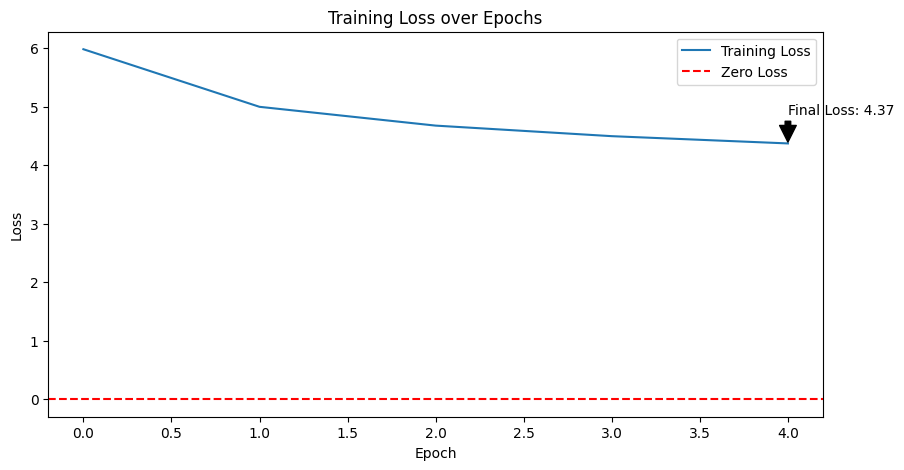

In [17]:
plot_loss(values)

### Embedding Layer Version

In [21]:
class EmbeddingLayerFFNN(nn.Module):
    def __init__(self, vocab,df, input_size, hidden_size, embedding_dim, dropout, num_layers, output_dim, context_size, lr):
        super().__init__()
        self.df = df
        self.lr = lr
        self.context_size = context_size
        self.vocab = vocab
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_size
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_dim)
        self.model = self.init_model()
        assert self.embedding.num_embeddings == len(self.vocab), "Embedding size and vocab size must match!"

    def _get_context_windows_batched(self, training_set: pd.DataFrame, N: int, batch_size: int):
        """
        Generator that yields batches of (context_window, next_token) pairs across the dataset,
        lazily building batches to avoid memory overload.
        """
        logging.info(f"..... Creating context windows .....")
        
        batch_context_windows = []

        for _, row in training_set.iterrows():
            tokens = row["merged_tokenized"]
            if len(tokens) <= N:
                continue  # skip rows that are too short
            for i in range(len(tokens) - N):
                context_window = tokens[i:i+N]
                next_token = tokens[i+N]
                batch_context_windows.append((context_window, next_token))

                if len(batch_context_windows) == batch_size:
                    yield batch_context_windows
                    batch_context_windows = []

        if batch_context_windows:
            yield batch_context_windows  # Yield last partial batch

        logging.info(f"..... Finished yielding context windows .....")
    
    def init_model(self):
        if '__UNK__' not in self.vocab:
            self.vocab['__UNK__'] = len(self.vocab)
        layers = []
        input_dim = self.embedding_dim * self.context_size
        for _ in range(self.num_layers):
            layers.append(nn.Linear(input_dim, self.hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(self.dropout))
            input_dim = self.hidden_dim
        layers.append(nn.Linear(self.hidden_dim, self.output_dim))
        return nn.Sequential(*layers)
    
    def fit(self, epochs, batch_size, device):
        # Move model to device
        self.to(device)
        
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        loss_values = []
        
        for epoch in range(epochs):
            logging.info(f"Epoch {epoch+1}/{epochs}")
            epoch_loss = 0
            batch_count = 0
            
            context_windows_batch = self._get_context_windows_batched(self.df, self.context_size, batch_size)
            
            for batch_idx, batch in enumerate(context_windows_batch):
                batch_X = []
                batch_y = []
                
                # Process all examples in the batch
                for context_window, next_token in batch:
                    context_window_indices = [self.vocab.get(token, self.vocab['__UNK__']) for token in context_window]
                    embedding = self.embedding(torch.tensor(context_window_indices, dtype=torch.long, device=device))
                    
                    # Add this example to the batch
                    batch_X.append(embedding.view(1, -1))
                    batch_y.append(self.vocab.get(next_token, self.vocab['__UNK__']))
                
                # Stack all examples in the batch
                X_tensor = torch.cat(batch_X, dim=0)  # Already on correct device
                y_tensor = torch.tensor(batch_y, dtype=torch.long, device=device)
                
                # Forward pass and optimization
                optimizer.zero_grad()
                output = self.model(X_tensor)
                loss = loss_fn(output, y_tensor)
                loss.backward()
                optimizer.step()
                
                # Track loss
                epoch_loss += loss.item()
                batch_count += 1
                
                if batch_idx % 100 == 0:
                    logging.info(f"Epoch {epoch+1}, Batch {batch_idx}: Loss = {loss.item():.4f}")
            
            # Calculate average loss for the epoch
            avg_epoch_loss = epoch_loss / batch_count if batch_count > 0 else 0
            loss_values.append(avg_epoch_loss)
            logging.info(f"Epoch {epoch+1} completed. Average loss: {avg_epoch_loss:.4f}")
        
        return loss_values
                    

In [22]:
tokenized_vocab, tokenized_vocab_size = get_pruned_vocab_tokenized(tokenized_df_train, "merged_tokenized", top_k=50000)


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = len(tokenized_vocab)
embedding_layer_network = EmbeddingLayerFFNN(
    tokenized_vocab, 
    tokenized_df_train, 
    embedding_dim, 
    1024, 
    1024, 
    0.5, 
    3, 
    tokenized_vocab_size, 
    3, 
    1e-4)
loss_values = embedding_layer_network.fit(5, 64, device)
plot_loss(loss_values)


2025-05-05 23:05:54,799 - INFO - Epoch 1/5
2025-05-05 23:05:54,799 - INFO - ..... Creating context windows .....
2025-05-05 23:05:54,989 - INFO - Epoch 1, Batch 0: Loss = 10.8163
2025-05-05 23:06:13,729 - INFO - Epoch 1, Batch 100: Loss = 8.0401
2025-05-05 23:06:32,510 - INFO - Epoch 1, Batch 200: Loss = 7.6529
2025-05-05 23:06:51,295 - INFO - Epoch 1, Batch 300: Loss = 8.8934
2025-05-05 23:07:10,072 - INFO - Epoch 1, Batch 400: Loss = 7.1551
2025-05-05 23:07:28,807 - INFO - Epoch 1, Batch 500: Loss = 7.6411
2025-05-05 23:07:47,501 - INFO - Epoch 1, Batch 600: Loss = 8.1577
2025-05-05 23:08:06,228 - INFO - Epoch 1, Batch 700: Loss = 6.1835
2025-05-05 23:08:24,988 - INFO - Epoch 1, Batch 800: Loss = 7.8130
2025-05-05 23:08:43,705 - INFO - Epoch 1, Batch 900: Loss = 7.8798
2025-05-05 23:09:02,424 - INFO - Epoch 1, Batch 1000: Loss = 8.7048
2025-05-05 23:09:21,156 - INFO - Epoch 1, Batch 1100: Loss = 8.1755
2025-05-05 23:09:39,389 - INFO - Epoch 1, Batch 1200: Loss = 7.8218
2025-05-05 23:

### Using Embedding Layer

Using my own embedding layer is not doing great looking at the first few epochs compared to using precomputated embeddings from the transformer

### Hybrid Aproach

I will now test some sort of Hybrid Approach, that  means using Transformer initialized embedding and fine tunine them with an embedding layer in the model

In [25]:
import random
class ContextWindowDataset(IterableDataset):
    def __init__(self, df, vocab, context_size):
        super().__init__()
        self.df = df
        self.vocab = vocab
        self.context_size = context_size

    def __iter__(self):
        # Shuffle documents each epoch
        rows = self.df.sample(frac=1).itertuples(index=False)
        N = self.context_size
        for row in rows:
            tokens = getattr(row, "merged_tokenized")
            L = len(tokens)
            if L <= N:
                continue
            # Shuffle window positions per document
            positions = list(range(L - N))
            random.shuffle(positions)
            for i in positions:
                context = tokens[i : i + N]
                target = tokens[i + N]
                # map to indices
                ctx_idxs = [self.vocab.get(t, self.vocab.get("__UNK__")) for t in context]
                tgt_idx = self.vocab.get(target, self.vocab.get("__UNK__"))
                yield torch.LongTensor(ctx_idxs), tgt_idx

In [26]:
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import math
class BenchmarkModel:
    def __init__(self, test_df, model_to_test):
        """Initialize with test DataFrame and a trained model."""
        self.test_df = test_df
        self.model = model_to_test.to(next(model_to_test.parameters()).device)
        self.context_size = self.model.context_size
        self.vocab = self.model.vocab
        self.rev_vocab = {i: t for t, i in self.vocab.items()}

    def predict_job_description(self, context_window, max_length=50, temperature=1.0):
        """Generate a sequence autoregressively from a starting context."""
        self.model.eval()
        device = next(self.model.parameters()).device
        tokens = context_window.copy()
        for _ in range(max_length):
            idxs = torch.LongTensor([
                self.vocab.get(t, self.vocab.get("__UNK__")) for t in tokens[-self.context_size:]
            ]).unsqueeze(0).to(device)
            logits = self.model(idxs).squeeze(0) / temperature
            probs = torch.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1).item()
            next_tok = self.rev_vocab.get(next_idx, "<unk>")
            tokens.append(next_tok)
        return tokens

    def perplexity(self):
        """Compute perplexity on the test set."""
        loss_fn = nn.CrossEntropyLoss()
        dataset = ContextWindowDataset(self.test_df, self.vocab, self.context_size)
        
        # Modified collate function to handle the dataset output correctly
        def collate_fn(batch):
            contexts = torch.stack([x[0] for x in batch])  # Get context_idxs
            targets = torch.LongTensor([x[1] for x in batch])  # Get target_idx
            return contexts, targets
        
        loader = DataLoader(
            dataset, 
            batch_size=32, 
            collate_fn=collate_fn
        )
        
        total_loss, count = 0.0, 0
        self.model.eval()
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(next(self.model.parameters()).device)
                targets = targets.to(next(self.model.parameters()).device)
                logits = self.model(inputs)
                loss = loss_fn(logits, targets)
                total_loss += loss.item()
                count += 1
                
        avg_loss = total_loss / count if count else float('nan')
        return math.exp(avg_loss)

    def bleu_score(self):
        """Compute corpus BLEU over next-token predictions."""
        dataset = ContextWindowDataset(self.test_df, self.vocab, self.context_size)
        refs, hyps = [], []
        for ctx_idxs, tgt_idx in dataset:  # Only unpack the two values that are actually returned
            pred_idx = self.model(ctx_idxs.unsqueeze(0).to(next(self.model.parameters()).device)).argmax(dim=-1).item()
            pred_token = self.rev_vocab.get(pred_idx, "<unk>")
            target_token = self.rev_vocab.get(tgt_idx, "<unk>")
            hyps.append([pred_token])
            refs.append([[target_token]])
        return corpus_bleu(refs, hyps)

    def rouge_score(self):
        """Compute average ROUGE-1 and ROUGE-L F1 over single-token predictions."""
        scorer = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=True)
        total1, totalL, count = 0.0, 0.0, 0
        dataset = ContextWindowDataset(self.test_df, self.vocab, self.context_size)
        for ctx_idxs, tgt_idx in dataset:  # Only unpack the two values that are actually returned
            pred_idx = self.model(ctx_idxs.unsqueeze(0).to(next(self.model.parameters()).device)).argmax(dim=-1).item()
            pred_token = self.rev_vocab.get(pred_idx, "<unk>")
            target_token = self.rev_vocab.get(tgt_idx, "<unk>")
            scores = scorer.score(target_token, pred_token)
            total1 += scores['rouge1'].fmeasure
            totalL += scores['rougeL'].fmeasure
            count += 1
        return {'rouge1': total1/count if count else 0.0,
                'rougeL': totalL/count if count else 0.0}
    

In [27]:
import random
from torch.utils.data import IterableDataset, DataLoader
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR, ReduceLROnPlateau
import math

class HybridFFNN(nn.Module):
    def __init__(self, vocab, hidden_size, dropout, num_layers, context_size, lr, pretrained_embeddings=None):
        super().__init__()
        self.vocab = vocab
        self.rev_vocab = {i: t for t, i in vocab.items()}
        self.lr = lr
        self.N = context_size
        self.context_size = context_size
        self.vocab_size = len(vocab)
        self.embedding_dim = (
            pretrained_embeddings.shape[1] if pretrained_embeddings is not None else 384
        )
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        if pretrained_embeddings is not None:
            w = torch.FloatTensor(pretrained_embeddings) if isinstance(pretrained_embeddings, np.ndarray) else pretrained_embeddings
            self.embedding.weight.data.copy_(w)
        layers = []
        input_dim = self.embedding_dim * self.context_size
        for _ in range(num_layers):
            layers.extend([nn.Linear(input_dim, hidden_size), nn.ReLU(), nn.Dropout(dropout)])
            input_dim = hidden_size
        layers.append(nn.Linear(hidden_size, self.vocab_size))
        self.model = nn.Sequential(*layers)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        flat = embedded.view(embedded.size(0), -1)
        return self.model(flat)

    def metrics(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        emb = self.embedding.weight.data
        return {'total_params': total, 'trainable_params': trainable,
                'emb_mean': emb.mean().item(), 'emb_std': emb.std().item()}

    def fit(self, train_df, val_df=None, batch_size=10000, epochs=10, device='cuda',
            optimizer_type='adamw', momentum=0.9, weight_decay=1e-2,
            scheduler_type='onecycle'):
        """Train with LR schedules and momentum-based optimizers."""
        self.to(device)
        N = self.context_size
        # compute steps
        total_windows = sum(max(len(row['merged_tokenized']) - N, 0) for _, row in train_df.iterrows())
        steps_per_epoch = math.ceil(total_windows / batch_size)
        # dataloader
        dataset = ContextWindowDataset(train_df, self.vocab, N)
        loader = DataLoader(dataset, batch_size=batch_size, collate_fn=lambda b: (
            torch.stack([x[0] for x in b]), torch.LongTensor([x[1] for x in b])
        ))
        # optimizer
        if optimizer_type=='sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=momentum, weight_decay=weight_decay)
        elif optimizer_type=='adamw':
            optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=weight_decay)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        # scheduler
        scheduler=None; step_every=None
        if scheduler_type=='onecycle':
            scheduler = OneCycleLR(optimizer, max_lr=self.lr, steps_per_epoch=steps_per_epoch, epochs=epochs, pct_start=0.3, anneal_strategy='cos')
            step_every='batch'
        elif scheduler_type=='cosine':
            scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
            step_every='epoch'
        elif scheduler_type=='plateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)
            step_every='val'
        loss_fn=nn.CrossEntropyLoss()
        # storage for logging
        loss_values = []
        # train loop
        for epoch in range(1,epochs+1):
            self.train(); total_loss=0.0; count=0
            logging.info(f"Epoch {epoch}/{epochs} start ({optimizer_type}+{scheduler_type})")
            running_loss_100 = 0.0
            for batch_idx, (inputs, targets) in enumerate(loader, start=1):
                inputs,targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                logits = self(inputs)
                loss = loss_fn(logits, targets)
                loss.backward(); optimizer.step()
                if step_every=='batch': scheduler.step()
                # update losses
                total_loss += loss.item(); count += 1
                running_loss_100 += loss.item()
                # log every 100 batches
                if batch_idx % 100 == 0:
                    avg100 = running_loss_100 / 100
                    loss_values.append(avg100)
                    logging.info(f"Epoch {epoch}, Batch {batch_idx}: Avg100 Loss = {avg100:.4f}")
                    running_loss_100 = 0.0
            avg=total_loss/count if count else float('nan')
            msg=f"Epoch {epoch} train loss: {avg:.4f}"
            if val_df is not None:
                vppl=BenchmarkModel(val_df,self).perplexity()
                msg+=f", val ppl: {vppl:.2f}"
                if scheduler_type=='plateau': scheduler.step(vppl)
            logging.info(msg)
            if step_every=='epoch' and scheduler is not None: scheduler.step()
        return loss_values

                


In [28]:
def create_pretrained_embedding_matrix(vocab, transformer_model, embedding_dim=384):
    """Create pretrained embeddings matrix with proper dimensionality."""
    # Get the transformer's output dimension (usually 768 for most models)
    sample_embedding = transformer_model.encode("test", show_progress_bar=False)
    transformer_dim = len(sample_embedding)
    
    # Initialize an embedding matrix with the transformer's dimension first
    temp_matrix = np.zeros((len(vocab), transformer_dim))
    
    # Fill the matrix with transformer embeddings
    for token, idx in vocab.items():
        try:
            # Encode the token using the transformer
            embedding = transformer_model.encode(token, show_progress_bar=False)
            temp_matrix[idx] = embedding
        except:
            # If encoding fails, leave as zeros
            continue
    
    # If needed, project down to desired embedding dimension
    if transformer_dim != embedding_dim:
        # Create a simple linear projection using SVD
        U, _, _ = np.linalg.svd(temp_matrix, full_matrices=False)
        embedding_matrix = U[:, :embedding_dim]  # Take first embedding_dim components
    else:
        embedding_matrix = temp_matrix
        
    return embedding_matrix



# Create pretrained embeddings
embedding_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')  # or your original transformer
pretrained_embeddings = create_pretrained_embedding_matrix(tokenized_vocab, embedding_model)


2025-05-07 08:49:07,334 - INFO - Use pytorch device_name: cuda:0
2025-05-07 08:49:07,335 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


In [29]:
model = HybridFFNN(
    vocab=tokenized_vocab,
    hidden_size=512,
    dropout=0.5,
    num_layers=2,
    context_size=3,
    lr=1e-4,
    pretrained_embeddings=pretrained_embeddings
)



In [30]:
# Train model - embeddings will be fine-tuned
val_df = tokenized_df_train.sample(frac=0.1)
loss_values = model.fit(
  tokenized_df_train,
  val_df=val_df,
  epochs=10,
  device=device,
  optimizer_type='adamw',
  weight_decay=1e-2,
  scheduler_type='onecycle'
)

2025-05-07 08:52:26,849 - INFO - Epoch 1/10 start (adamw+onecycle)
2025-05-07 08:53:02,976 - INFO - Epoch 1, Batch 100: Avg100 Loss = 10.8137
2025-05-07 08:53:38,730 - INFO - Epoch 1, Batch 200: Avg100 Loss = 10.8057
2025-05-07 08:54:14,608 - INFO - Epoch 1, Batch 300: Avg100 Loss = 10.7939
2025-05-07 08:54:50,682 - INFO - Epoch 1, Batch 400: Avg100 Loss = 10.7711
2025-05-07 08:55:26,389 - INFO - Epoch 1, Batch 500: Avg100 Loss = 10.7224
2025-05-07 08:56:02,150 - INFO - Epoch 1, Batch 600: Avg100 Loss = 10.6203
2025-05-07 08:56:38,030 - INFO - Epoch 1, Batch 700: Avg100 Loss = 10.4221
2025-05-07 08:57:14,831 - INFO - Epoch 1, Batch 800: Avg100 Loss = 10.0714
2025-05-07 08:57:50,746 - INFO - Epoch 1, Batch 900: Avg100 Loss = 9.5309
2025-05-07 08:58:26,763 - INFO - Epoch 1, Batch 1000: Avg100 Loss = 8.8120
2025-05-07 08:59:02,658 - INFO - Epoch 1, Batch 1100: Avg100 Loss = 8.1321
2025-05-07 08:59:38,459 - INFO - Epoch 1, Batch 1200: Avg100 Loss = 7.7579
2025-05-07 09:00:14,332 - INFO - E

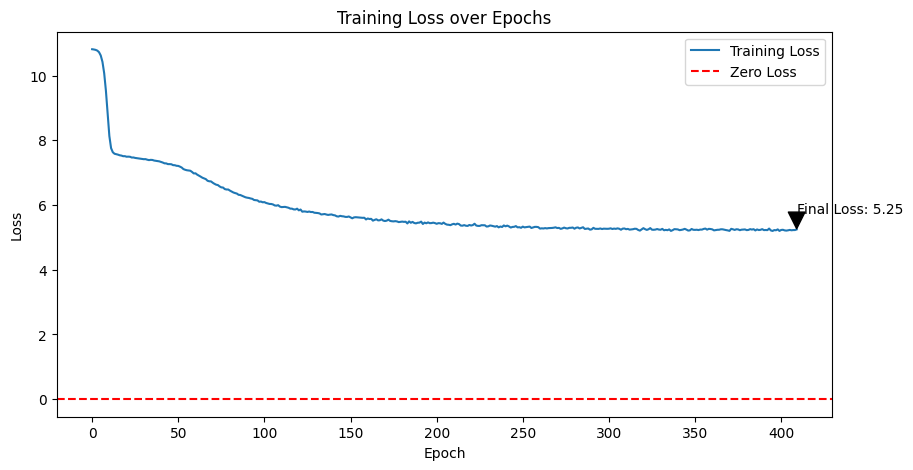

In [31]:
plot_loss(loss_values)

In [32]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

save_model(model, "model_cache/hybrid_ffnn_model.pth")

### Report

Looking at the value of the loss it seems like we are hitting local minimum it doest really go below 5 when trained for 5 epochs

the difference of loss from the different epochs are not big which suggests again perhaps local minimum are being hit.

I need to try to get out of this local minimum that is being hit

looking at this article 
https://mohitmishra786687.medium.com/the-curse-of-local-minima-how-to-escape-and-find-the-global-minimum-fdabceb2cd6a

SGD might be interesting to get out of a local minimum or any momentum based optimizers

and learning rate schedlues


https://medium.com/@shazanansar/escaping-the-trap-of-local-minima-why-optimization-algorithms-get-stuck-and-how-to-break-free-6e3042a6d9c9

In [43]:
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import math
class BenchmarkModel:
    def __init__(self, test_df, model_to_test):
        """Initialize with test DataFrame and a trained model."""
        self.test_df = test_df
        self.model = model_to_test.to(next(model_to_test.parameters()).device)
        self.context_size = self.model.context_size
        self.vocab = self.model.vocab
        self.rev_vocab = {i: t for t, i in self.vocab.items()}

    def predict_job_description(self, context_window, max_length=50, temperature=1.0):
        """Generate a sequence autoregressively from a starting context."""
        self.model.eval()
        device = next(self.model.parameters()).device
        tokens = context_window.copy()
        
        for _ in range(max_length):
            idxs = torch.LongTensor([
                self.vocab.get(t, self.vocab.get("__UNK__")) for t in tokens[-self.context_size:]
            ]).unsqueeze(0).to(device)
            
            logits = self.model(idxs).squeeze(0) / temperature
            probs = torch.softmax(logits, dim=-1)
            
            # Set probability of UNK token to 0
            unk_idx = self.vocab.get("__UNK__", -1)
            if unk_idx >= 0:
                probs[unk_idx] = 0
                # Renormalize if needed
                if probs.sum() > 0:
                    probs = probs / probs.sum()
                else:
                    # If all probs are zero, use uniform distribution
                    probs = torch.ones_like(probs) / len(probs)
            
            next_idx = torch.multinomial(probs, num_samples=1).item()
            next_tok = self.rev_vocab.get(next_idx, "<unk>")
            tokens.append(next_tok)
            
            # Optional: stop if end token is generated
            if next_tok == "__END__" or next_tok == "<END>":
                break
                
        return tokens

    def perplexity(self):
        """Compute perplexity on the test set."""
        loss_fn = nn.CrossEntropyLoss()
        dataset = ContextWindowDataset(self.test_df, self.vocab, self.context_size)
        
        # Modified collate function to handle the dataset output correctly
        def collate_fn(batch):
            contexts = torch.stack([x[0] for x in batch])  # Get context_idxs
            targets = torch.LongTensor([x[1] for x in batch])  # Get target_idx
            return contexts, targets
        
        loader = DataLoader(
            dataset, 
            batch_size=32, 
            collate_fn=collate_fn
        )
        
        total_loss, count = 0.0, 0
        self.model.eval()
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(next(self.model.parameters()).device)
                targets = targets.to(next(self.model.parameters()).device)
                logits = self.model(inputs)
                loss = loss_fn(logits, targets)
                total_loss += loss.item()
                count += 1
                
        avg_loss = total_loss / count if count else float('nan')
        return math.exp(avg_loss)

    def bleu_score(self):
        """Compute corpus BLEU over next-token predictions."""
        dataset = ContextWindowDataset(self.test_df, self.vocab, self.context_size)
        refs, hyps = [], []
        for ctx_idxs, tgt_idx in dataset:  # Only unpack the two values that are actually returned
            pred_idx = self.model(ctx_idxs.unsqueeze(0).to(next(self.model.parameters()).device)).argmax(dim=-1).item()
            pred_token = self.rev_vocab.get(pred_idx, "<unk>")
            target_token = self.rev_vocab.get(tgt_idx, "<unk>")
            hyps.append([pred_token])
            refs.append([[target_token]])
        return corpus_bleu(refs, hyps)

    def rouge_score(self):
        """Compute average ROUGE-1 and ROUGE-L F1 over single-token predictions."""
        scorer = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=True)
        total1, totalL, count = 0.0, 0.0, 0
        dataset = ContextWindowDataset(self.test_df, self.vocab, self.context_size)
        for ctx_idxs, tgt_idx in dataset:  # Only unpack the two values that are actually returned
            pred_idx = self.model(ctx_idxs.unsqueeze(0).to(next(self.model.parameters()).device)).argmax(dim=-1).item()
            pred_token = self.rev_vocab.get(pred_idx, "<unk>")
            target_token = self.rev_vocab.get(tgt_idx, "<unk>")
            scores = scorer.score(target_token, pred_token)
            total1 += scores['rouge1'].fmeasure
            totalL += scores['rougeL'].fmeasure
            count += 1
        return {'rouge1': total1/count if count else 0.0,
                'rougeL': totalL/count if count else 0.0}
    

In [44]:
benchmark_model = BenchmarkModel(tokenized_df_train, model)

In [ ]:


perplexity = benchmark_model.perplexity()

print(f"Perplexity: {perplexity}")


In [39]:
print("Perplexity: ", perplexity)

Perplexity:  147.41035956339098


In [68]:
generated_job_description = benchmark_model.predict_job_description(["Software", "Engineer", "Internship"], 50, 0.5)
for token in generated_job_description:
    print(token, end=" ")
print()

Software Engineer Internship ( Remote ) ( Remote ) Hybrid ) - Day Shift I - $ - $ 32-52 per hour - $ 18.00 $ per hour shift schedule , shift , weekends , holidays 9 pay period 2023 us . expertise , including limited , needed , manage firm business projects 


In [65]:
class SimpleModel(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim, vocab, context_size=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size), 
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_dim)
        )
        # Add required attributes
        self.vocab = vocab
        self.context_size = context_size
        self.rev_vocab = {i: t for t, i in vocab.items()}
    
    def forward(self, x):
        return self.model(x)

# Create model with required attributes
simple_model = SimpleModel(
    input_dim=384, 
    hidden_size=1024, 
    output_dim=len(tokenized_vocab),
    vocab=tokenized_vocab,
    context_size=3  # Set to match your training
)

# Load weights
state_dict = torch.load("model_cache/network_deep_lr.pth")
new_state_dict = {}
for k, v in state_dict.items():
    new_key = f"model.{k}"
    new_state_dict[new_key] = v

simple_model.load_state_dict(new_state_dict)
benchmark_model_deep = BenchmarkModel(tokenized_df_train, simple_model)

generated_job_description = benchmark_model.predict_job_description(["Software", "Engineer", "Internship"], 50, 0.5)
for token in generated_job_description:
    print(token, end=" ")
print()


Software Engineer Internship ( Industrial ) - REMOTE - Part Time - Full Time - $ 32-58 per hour - $ 20.00 $ per hour shift day day operations , including limited limited , limited , individual must able perform essential functions job . reasonable accommodations may made enable individuals disabilities perform essential 


In [35]:
bleu_score = benchmark_model.bleu_score()
rouge_score = benchmark_model.rouge_score()

print(f"Perplexity: {perplexity}")
print(f"BLEU Score: {bleu_score}")
print(f"ROUGE Score: {rouge_score}")

KeyboardInterrupt: 

### REport

After this attempt with a momentum based optimizer and a LR scheduler it still seems like we are hitting some sort of plateau this could just mean the FFNN are not very good at the task that is next token prediction the RNN might be a better approach


A very counter intuitive thing is happening the architecture in which we start with pretrained  embeddings from the transformer is not performing as well with a model that doesnt fine tune anything but sticks to the static semantices generated by the transformer

it looks like fine tuning on top of the rich semantics from the transformer is making the model deteriorate the semantics ?